In [42]:
import numpy as np
from matplotlib import pyplot as plt

In [43]:
# Boundary conditions
def apply_bcs(K_gl,F_gl,dof,value):
    phi = 1.0
    bignumber = 10.0**15
    K_gl[dof,dof] += bignumber*phi*phi
    F_gl[dof] += bignumber*float(value)*phi  

In [44]:
# Global index of local DOF
def gl_index(elem_index,local_dof):
    return elem_index + local_dof

In [45]:
# Global stiffness matrix and mass matrix
def GlobalSystem(E,L,A,n_elem,bc1,bc2):
    
    # Element stiffness matrix and element load vector
    k_elem = E*A/L * np.array([[1.0, -1.0], [-1.0, 1.0]])
    m_elem = rho*A*h/2 * np.array([[1.0,0.0],[0.0,1.0]])
    f_elem = np.array([0.0, 0.0])

    # Global stiffness matrix and load vector
    K_gl = np.zeros((n_elem+1, n_elem+1))
    F_gl = np.zeros((n_elem+1))
    M_gl = np.zeros((n_elem+1, n_elem+1))
    # Assembly of elements
    for i_el in range(n_elem):
        for i_loc in range(2):
            i_gl = gl_index(i_el, i_loc)
            F_gl[i_gl] += f_elem[i_loc]
            for j_loc in range(2):
                j_gl = gl_index(i_el, j_loc)
                K_gl[i_gl,j_gl] += k_elem[i_loc, j_loc]
                M_gl[i_gl,j_gl] += m_elem[i_loc, j_loc]

    # Boundary conditions
    # apply_bcs(K_gl, F_gl, 0, bc1)
    # apply_bcs(K_gl, F_gl, n_elem, bc2)

    # Approximate solution
    # uh = np.linalg.solve(K_gl, F_gl)

    return K_gl, M_gl

In [46]:
# Newmark's method
def newmark(K, M, C, u, v, acel, p_next, dt, gamma, beta):
    #acel0 = np.matmul(np.linalg.inv(M),(p0 - C*v0 - K*u0))

    # Degrees of freedom
    dofs = K.shape[0]
    # Integration constants
    alpha = [
        1.0/(beta*dt**2.0),
        gamma/(beta*dt),
        1.0/(beta*dt),
        1.0/(2.0*beta)-1.0,
        gamma/beta-1.0,
        (gamma/beta-2.0)*dt/2.0,
        (1.0-gamma)*dt,
        gamma*dt
        ]

    # Effective stiffness matrix
    Keff = K + alpha[0]*M + alpha[1]*C
    
    # Keff inverse
    Kinv = np.linalg.inv(Keff)
    

    # Integration
    # Vector of effective forces at time
    pef = np.zeros((dofs))
    # Vector of displacements at time
    u_next = np.zeros((dofs))
    # Vector of accelerations  and velocities at time
    acel_next = np.zeros((dofs))
    v_next = np.zeros((dofs))

    # Vector of effective forces p
    term1 = alpha[0]*u + alpha[2]*v + alpha[3]*acel
    term2 = alpha[1]*u + alpha[4]*v + alpha[5]*acel
    pef_next = p_next + np.matmul(M,term1) + np.matmul(C,term2)
    # Vector of displacements u
    u_next = np.matmul(Kinv,pef_next)
    # Vector of accelerations acel and velocities v 
    acel_next = alpha[0]*(u_next-u) - alpha[2]*v - alpha[3]*acel
    v_next = v + alpha[6]*acel + alpha[7]*acel_next  
    
    return u_next,v_next,acel_next

In [51]:
def plot(x,y,labelx,labely,title):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')
    plt.title(str(title))
    plt.xlabel(str(labelx))
    plt.ylabel(str(labely))
    plt.plot(x, y)
    plt.show()

def plot_interior(x0,xf,n_elem,func,labelx,labely,title):
    h = float(xf-x0)/n_elem
    x = np.array([[x0+h*el,x0+h*(el+1)] for el in range(n_elem)])
    x = x.flatten()
    y = np.array([[func[el],func[el]] for el in range(n_elem)])
    y = y.flatten()
    plot(x,y,labelx,labely,title)

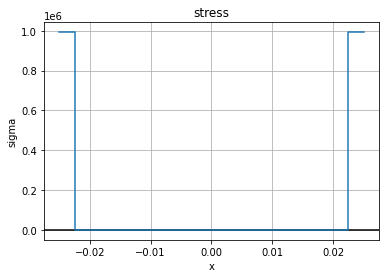

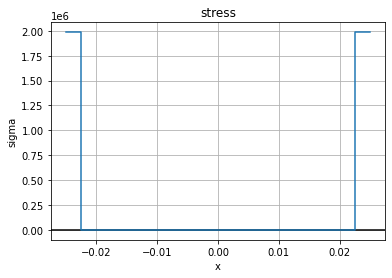

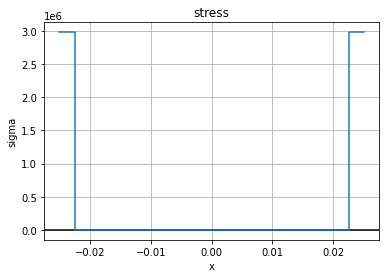

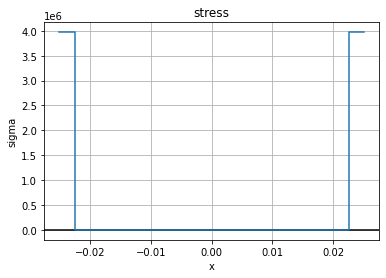

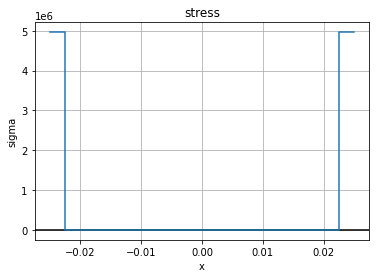

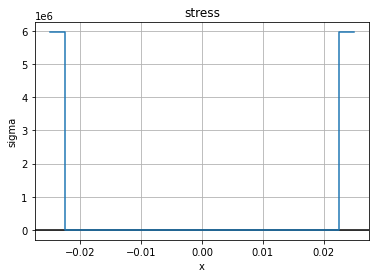

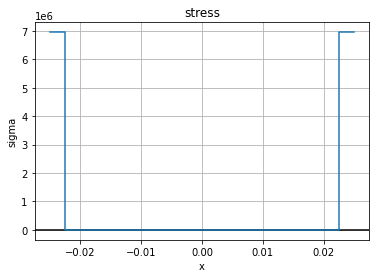

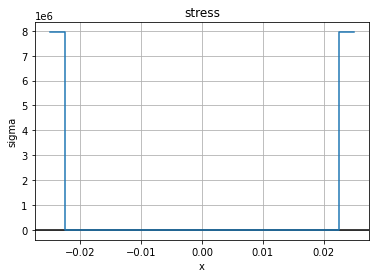

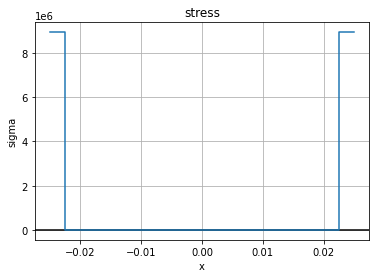

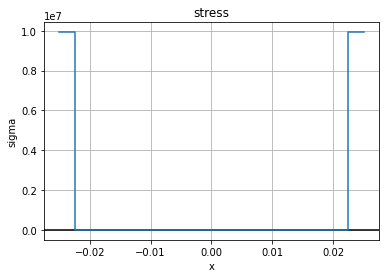

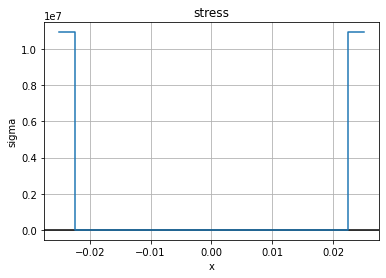

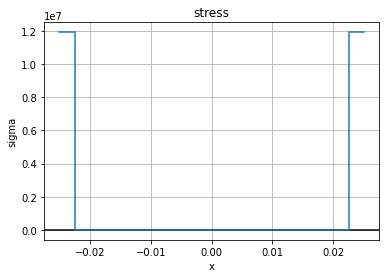

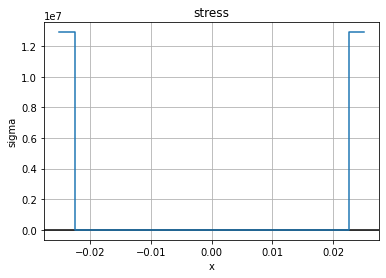

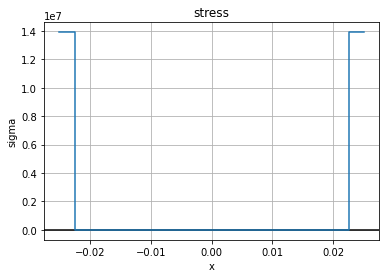

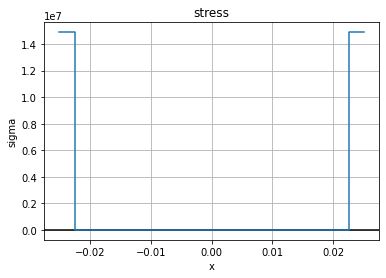

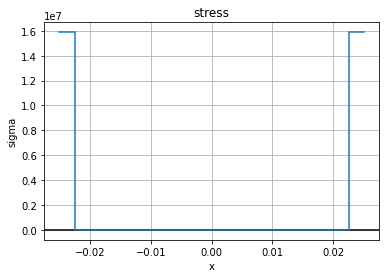

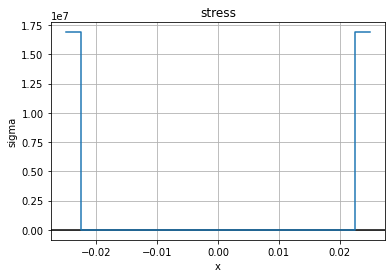

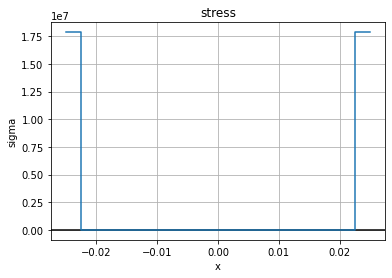

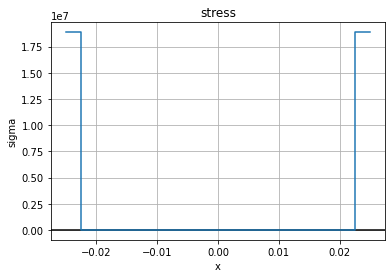

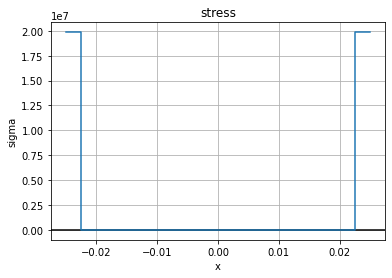

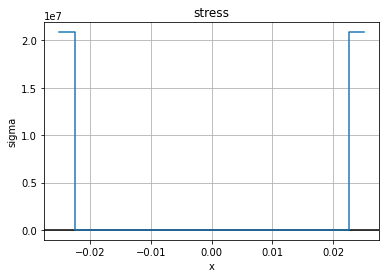

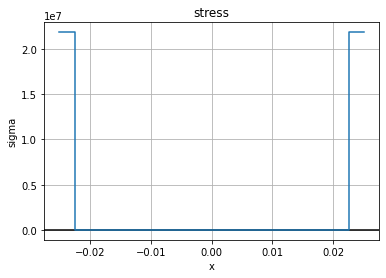

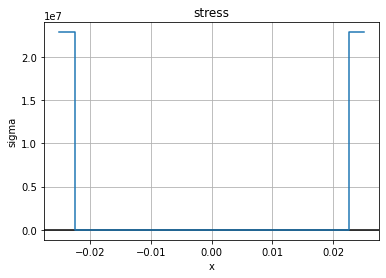

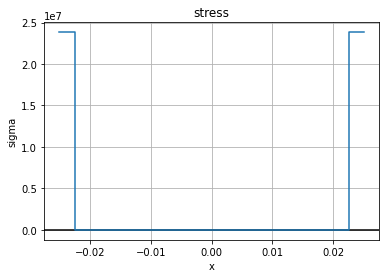

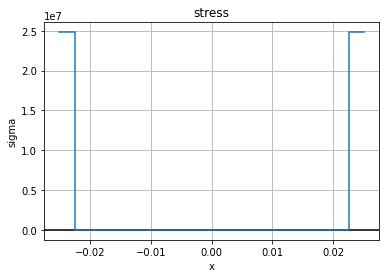

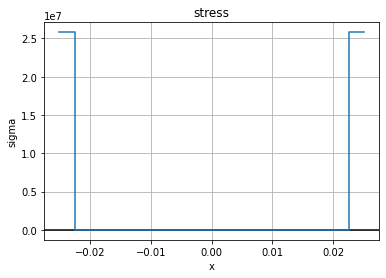

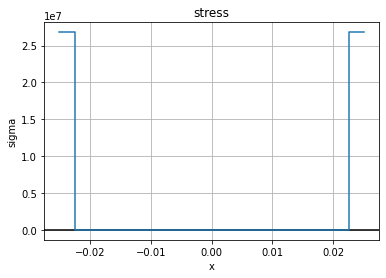

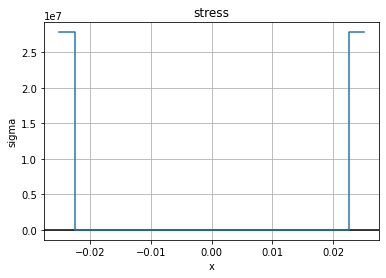

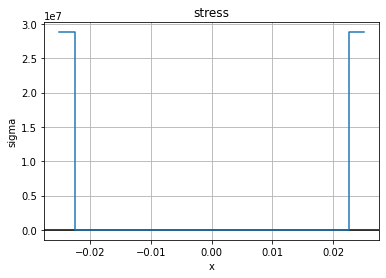

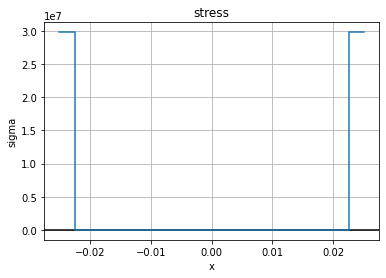

In [53]:
# Global algorithm (load applied in all time steps)

# Input parameters

# Material parameters
E = 275.0*10**9 #(Pa)
L = 0.05 #(m)
A = 1.0 #(unit area)
Gc = 100.0 #(N/m)
stress_c = 300.0*10**6 #(Pa)
rho = 2750.0 #(kg/m3)

# Boundary conditions
# Strain rate
strain_rate = 1.0*10**4 #(s-1)
# Velocities
bc1 = -strain_rate*L/2.0
bc2 = strain_rate*L/2.0

# Mesh
n_elem = 20
h = L/n_elem
dofs = n_elem + 1

# Time steps
n_steps = 30

# Initial data
# Initial displacement (u0)
u0 = np.zeros((dofs))
# Initial velocity (v0): velocity profile (vel) is a function v(x)
vel = strain_rate*L/2.0
n_points = dofs
l = np.linspace(-L/2, L/2, n_points)
# v0 = np.array([2*vel/L*x for x in l])
# v0 = np.round(v0, 8)

v0 = np.zeros((dofs))
v0[0] = -vel
v0[dofs-1] = vel


# Initial acceleration (acel0)
acel0 = np.zeros((dofs))
# Load (p)
p = np.zeros((n_steps+1,dofs))

# Time integration
dt = 3.61*10**-11 #(s)
gamma = 0.5
beta = 0.5 
C = np.zeros((dofs,dofs))  

# Get K_gl and M_gl
K,M = GlobalSystem(E,L,A,n_elem,bc1,bc2)
# Get u,v and a
u = u0
v = v0
acel = acel0

for n in range(n_steps):
    # plot(l,u,"x","v","velocity")
    u,v,acel = newmark(K,M,C,u,v,acel,p[n+1],dt,gamma,beta)
    strain = np.zeros(n_elem)
    stress = np.zeros(n_elem)
    for el in range(n_elem):
        strain[el] = (u[el+1] - u[el])/h
        stress[el] = E*strain[el]
    plot_interior(-L/2,L/2,n_elem,stress,"x","sigma","stress")
    # print('step')
    # print(n+1)
    # print(stress)